# Imports

In [180]:
from uuid import uuid4
import os
import shlex
import subprocess
from collections import defaultdict

# used only for plotting
import seaborn as sns
import pandas as pd

# Implementation
Uses standard Python libraries, `grep` and `sort`.

In [252]:
def ploidity_from_vcf(path):
    """
    Calculate ploidity from .vcf file
    """

    # chrom namer whose count of copies differs from ploidity
    bad_chroms = {'Y', 'X', 'M', 'chrX', 'chrY', 'chrM'}

    with open(path, 'r') as f:
        for line in f:
            # skip comments and heading
            if line.startswith('#'):
                continue

            # skip bad chroms
            fields = line.split('\t')
            chrom = fields[0]
            if chrom in bad_chroms:
                continue

            # .vcf contains 8 fixed columns + FORMAT + individual columns
            # i.e. first of individual columns is the 10th

            # find genotype field index
            index = fields[8].split(':').index('GT')
            ploidity = len(fields[9].split(':')[index].split('/'))
            return ploidity


def het_dist_histogram(path, name=None, return_list=True):
    """
    Calculate the histogram for distribution of lengths of intervals between
    heterozygotes. The i-th element of histogram will be equal to the number of
    neighbouring heterozygotes that have distance between them equal to i.

    path - path to .vcf file

    name - if None, calculates statistics across all individuals (default);
        else calculates only for specified individual.

    return_list - if True, return list where index i corresponds to distance
        and i-th value corresponds to count; 
        else returns dict {distance: count}
    """

    # if name is specified, we need to identify the column index
    if name is not None:
        with open(path, 'r') as f:
            for line in f:
                if line.startswith('#CHROM'):
                    header = line.split('\t')
                    if name in header:
                        column_index = header.index(name)
                        break
                    else:
                        print('Individual ' + name + ' not found.')
                        print('Pick one of the below:')
                        print(*header[9:], sep='\t')
                        return

    # lets sort .vcf file by chromosome first and by position second
    # and save the results in temp file
    tmp_file = str(uuid4())
    try:
        command = f"grep -v '#' {path} | sort -k1,1 -k2n > {tmp_file}"
        proc = subprocess.run(command, shell=True, capture_output=True)
        proc.check_returncode()

    except Exception as e:
        print(proc.stderr.decode('utf-8'))
        os.remove(tmp_file)
        raise e

    else:

        def parse_line(line):
            """
            Parses a line from .vcf file.

            Returns chrom, position and flag - list of bool (1 value for each individual)

            flag[i] is True if i-th individual is heterozygous at this position.
            """

            fields = line.split('\t')
            chrom = fields[0]
            position = int(fields[1])
            flag = []

            # locate GT field index
            GT_index = fields[8].split(':').index('GT')

            def het_zyg(genotype_data):
                """
                Parse genotype data from .vcf file
                Return True if heterozygousity is observed, else False
                """
                a1, a2 = genotype_data.split(':')[GT_index].split('/')
                return a1 != a2

            if name is None:
                for i in range(9, len(fields)):
                    flag.append(het_zyg(fields[i]))

            else:
                flag.append(het_zyg(fields[column_index]))

            return chrom, position, flag

        counts = defaultdict(int)
        with open(tmp_file, 'r') as f:
            prev_stat = parse_line(next(f))
            for line in f:
                next_stat = parse_line(line)

                # different chromosomes
                if prev_stat[0] != next_stat[0]:
                    prev_stat = next_stat
                    continue

                for hetzyg1, hetzyg2 in zip(prev_stat[2], next_stat[2]):
                    if hetzyg1 and hetzyg2:
                        distance = next_stat[1] - prev_stat[1]
                        counts[distance] += 1

                prev_stat = next_stat

        # clean up
        os.remove(tmp_file)

        if return_list:
            # construct list from counts dictionary
            results = [0] * (max(counts.keys()) + 1)
            for k, v in counts.items():
                results[k] = v
            return results

        else:
            return counts

In [260]:
def plot_histogram(H, name):
    """
    Plot histogram from the results of het_dist_histogram function ()
    """
    max_count = max(H)
    for i, h in enumerate(H):
        if i and h < max_count * 0.01:
            last_index = i
            break

    H_plot = H[:last_index]

    x = [i for i in range(last_index)]

    ax_fontsize = 15
    title_fontsize = 18

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.histplot(x=x, weights=H_plot, bins=10)
    ax.set_xlim([0, ax.get_xlim()[1]])
    ax.set_xlabel('Distance', fontsize=ax_fontsize)
    ax.set_ylabel('Count', fontsize=ax_fontsize)

    suptitle = '\nDistribution of lengths of intervals\nbetween heterozygotes'

    if name is None:
        title = '(across all individuals)'
    else:
        title = f'({name})'

    ax.set_title(title, fontsize=title_fontsize)
    ax.grid()

    fig.suptitle(suptitle, fontsize=title_fontsize+1, x=0.55)
    fig.tight_layout()

# Example usage
Using `.vcf` file from [here](https://stepik.org/lesson/295219/step/12?unit=276890).

The filt is `58835` lines including counts and contains genotype data for 4 individuals.

In [251]:
ls - l data_for_dtrio.vcf

-rw-rw-r-- 1 iam28th iam28th 24367049 июн 10 19:47 data_for_dtrio.vcf


In [254]:
file = 'data_for_dtrio.vcf'
ploidity_from_vcf(file)

2

In [255]:
# calculate stats across all 4 individuals
H_all = het_dist_histogram(file, name=None)

In [257]:
# calculate stats for ind1
H_Ind1 = het_dist_histogram(file, name='ind1')

Individual ind1 not found.
Pick one of the below:
Ind4	Ind3	Ind1	Ind2



In [258]:
# whoops, I mean Ind1
H_Ind1 = het_dist_histogram(file, name='Ind1')

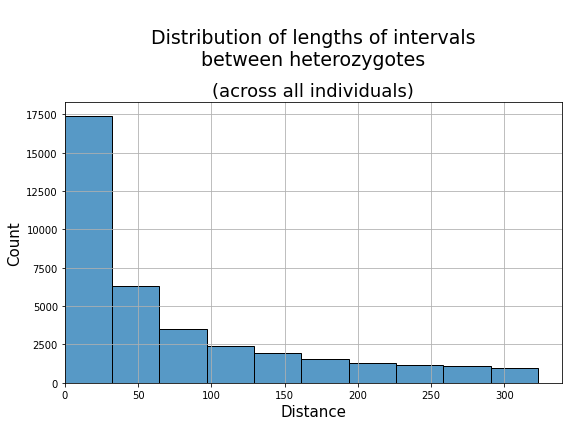

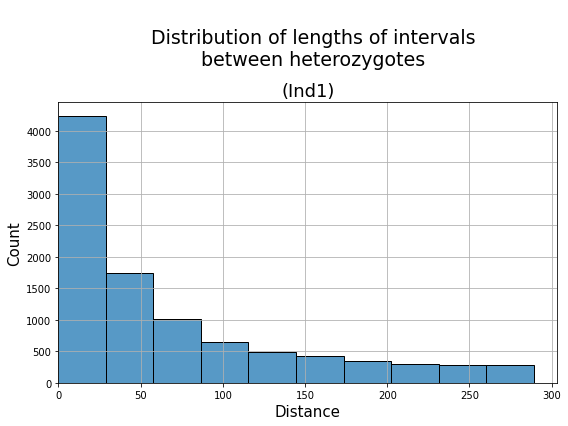

In [261]:
# visualize
plot_histogram(H_all, name=None)
plot_histogram(H_Ind1, name='Ind1')

The distance seem to be close to Poisson distribution, which makes sense if we suppose that probability to be heterozygous for all positions in the genome is relatevely close.